# Chapter 4: Time Series Forecasting with LSTMs

#### Imports

In [58]:
# OS
import os 

# plotting 
import matplotlib.pyplot as plt 
import seaborn 
from pylab import rcParams

# linalg
import numpy as np 

# dfs
import pandas as pd

#preprocess
from sklearn.preprocessing import MinMaxScaler

# colored print
import termcolor
from termcolor import colored

#torch 
import torch 
from torch import nn, optim

In [59]:
rcParams['figure.figsize'] = 18,10

#### Fetch the dataset

In [60]:
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 7.15MB/s]


In [61]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2022-01-27 15:25:37--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... failed: Connection timed out.
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1050571 (1.0M) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv.1’

time_series_covid19 100%[===================>]   1.00M  --.-KB/s    in 0.06s   

2022-01-27 15:27:47 (17.3 MB/s) - ‘time_series_covid19_confirmed_global.csv.1’ saved [1050571/1050571]



#### Load and view dataset

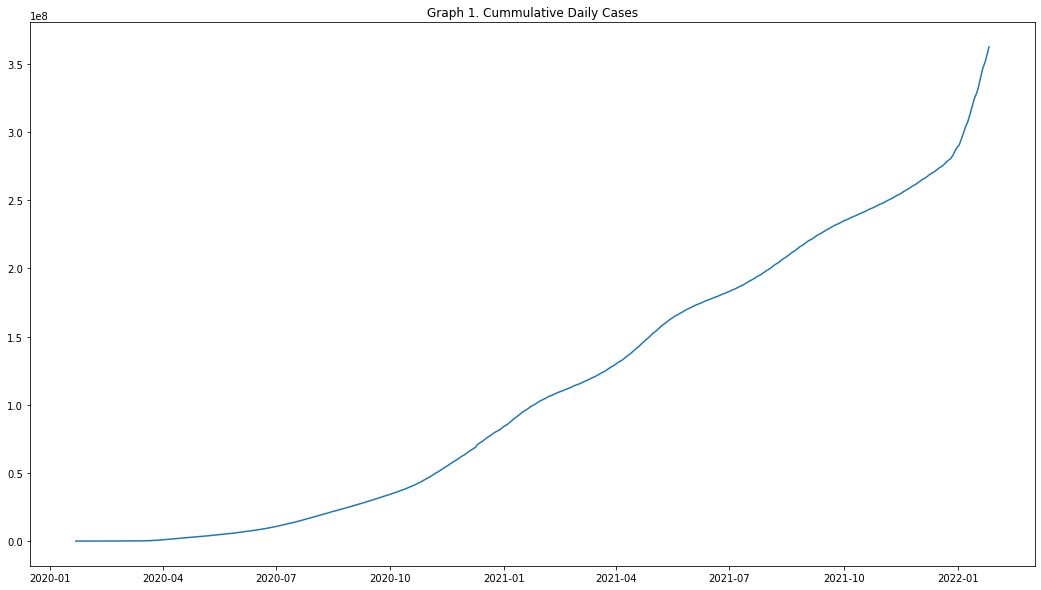

In [62]:
# assign path 
PATH_DATA = '/content/time_series_covid19_confirmed_global.csv'
# reading
df = pd.read_csv(PATH_DATA)

# we need to get rid of the first four columns:
# PROVINCE, COUNTRY, LAT & LONG --> Not much information except prediction per country ?
df = df.iloc[:, 4:]

# check the nans == 0
assert df.isnull().sum().sum() == 0

# lets do a cummulative sum 
daily_cases = df.sum(axis=0)
# get the index of the daily cases and convert to timestamp 
daily_cases.index = pd.to_datetime(daily_cases.index)
# lets look at it 
daily_cases.head()
# lets visualize it 
plt.plot(daily_cases);
plt.title("Graph 1. Cummulative Daily Cases");
plt.show()

#### Preprocessing: Removing cummulative 

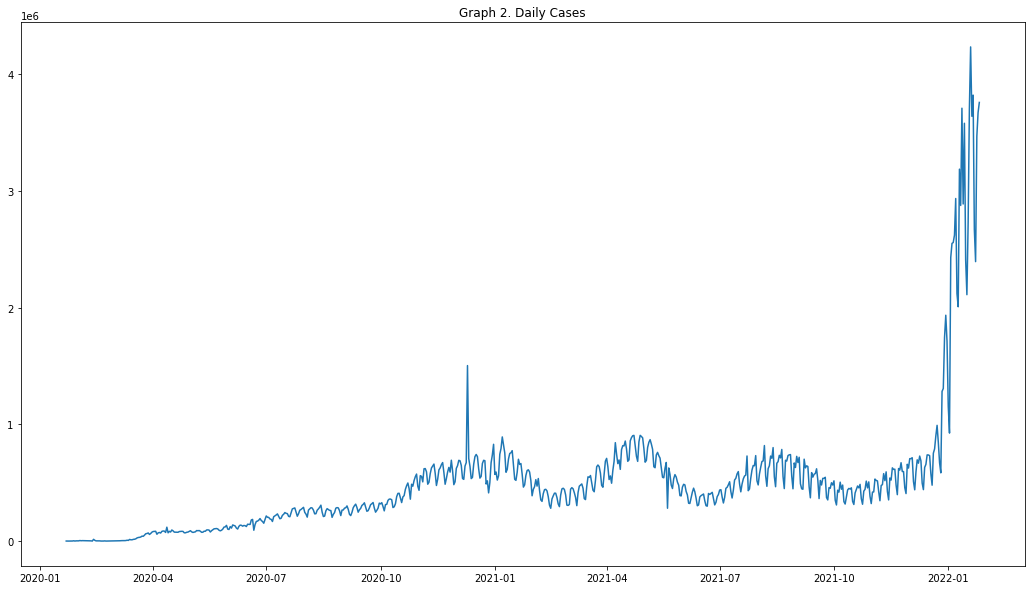

In [63]:
# removing the cummulative by removing the current value from the previous 
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()
plt.plot(daily_cases);
plt.title("Graph 2. Daily Cases");
plt.show()

In [64]:
# lets reserve 90% for training, 10% for testing
test_size = round(len(daily_cases)*0.1)
#test_size=14

# the training data 
train_data = daily_cases[:-test_size]
test_data = daily_cases[-test_size:]

#check the shape 
#print(train_data.shape, test_data.shape)

# we also need to scale our data 
scaler = MinMaxScaler()
# fitting to the data
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
# quick func
def scale_data(SCALE, DATA): return SCALE.transform(np.expand_dims(DATA, axis=1))
# transforming the previous data 
train_data = scale_data(scaler, train_data)
test_data = scale_data(scaler, test_data)

# we also need to chunk the sequences, because they are continious 
def create_sequences(DATA, LENGTH):
  xs,ys = [],[]
  for k in range(len(DATA)-LENGTH-1):
    x = DATA[k:(k+LENGTH)]
    y = DATA[k+LENGTH]
    xs.append(x), ys.append(y)
  return np.array(xs), np.array(ys)

# make the defined sequences 
SEQ_LENGTH = 5
# the data we will use 
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)
# converting the vals 
# TRAINING
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
# TESTING
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# lets look at the shape of each of these samples 
X_train.shape

torch.Size([656, 5, 1])

#### Build the model !

In [97]:
# building the LST class 
# we pass in the number of features, number of hidden units, the sequence length and the number of layers
class nCOV_LSTM(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, DEVICE,n_layers=2):
    super(nCOV_LSTM, self).__init__()
    # the values
    self.device = DEVICE
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers 
    # the actual LSTM 
    self.lstm = nn.LSTM(
                        input_size=n_features,
                        hidden_size = n_hidden,
                        num_layers = n_layers,
                        dropout=0.5
                        )
    # the linear layer: in--> number of hidden units, and out is one bc we are predicting a single value 
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  
  # we need to reset the state after each sample --> stateless LSTM
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=self.device),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=self.device)
        )
  # defining the forwards pass 
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
                                      sequences.view(len(sequences), self.seq_len,-1),
                                      self.hidden)
    last_time_step = lstm_out.view(
                                  self.seq_len, len(sequences), self.n_hidden
                                   )[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

#### Training Loop 

In [194]:
def train_LSTM_model(MODEL, TRAIN_DATA, TRAIN_LABELS,EPOCHS,DEVICE,TEST_DATA=None, TEST_LABELS=None):
  # sending them all to device?
  TRAIN_DATA = TRAIN_DATA.to(DEVICE)
  TRAIN_LABELS = TRAIN_LABELS.to(DEVICE)
  if (TEST_DATA is not None) and (TEST_LABELS is not None):
    TEST_DATA = TEST_DATA.to(DEVICE)
    TEST_LABELS = TEST_LABELS.to(DEVICE)
  # define our loss function 
  loss_func = nn.MSELoss(reduction='sum')
  # optimizer 
  opt = optim.Adam(MODEL.parameters(), lr=1e-3)
  # history tracker
  train_history,test_history = np.zeros(EPOCHS), np.zeros(EPOCHS)
  # looping through the epochs 
  for epoch in range(EPOCHS):
    # putting into train mode 
    #MODEL.train()
    # reset the state just in case 
    MODEL.reset_hidden_state()
    # predicting 
    y_pred = MODEL(TRAIN_DATA)
    # calculate the loss 
    loss = loss_func(y_pred.float(), TRAIN_LABELS)
    # appending the training history 
    train_history[epoch] = loss.item()
    # testing 
    if TEST_DATA is not None:
      with torch.no_grad():
        #MODEL.eval()
        # with the test data
        test_pred = MODEL(TEST_DATA)
        # test loss 
        test_loss = loss_func(test_pred.float(), TEST_LABELS)
        test_history[epoch] = test_loss.item()
        # debug 
        if epoch % 10 == 0:
          test_text = f"\nTESTING: EPOCH: {epoch} TRAIN-LOSS: {loss.item()} TEST-LOSS: {test_loss.item()}"
          print(colored(test_text,'red','on_white'))
    elif epoch % 10 == 0:
      train_text = f"\nTRAINING: EPOCH: {epoch} LOSS: {loss.item()}"
      print(colored(train_text, 'green'))
    # zeroing 
    opt.zero_grad()
    # backprop
    loss.backward()
    # stepping
    opt.step()
  
  return MODEL, train_history, test_history

In [195]:
# setting the device
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# insantiate model 
model = nCOV_LSTM(n_features=1, n_hidden=256,seq_len=SEQ_LENGTH, DEVICE=device, n_layers=3)
# sending to device
model = model.to(device)

In [134]:
model, train_history, test_history = train_LSTM_model(model, X_train, y_train,30, device, X_test,y_test)


TESTING: EPOCH: 0 TRAIN-LOSS: 75.61992645263672 TEST-LOSS: 113.64680480957031

TESTING: EPOCH: 10 TRAIN-LOSS: 45.704708099365234 TEST-LOSS: 100.82435607910156

TESTING: EPOCH: 20 TRAIN-LOSS: 21.806142807006836 TEST-LOSS: 85.08820343017578


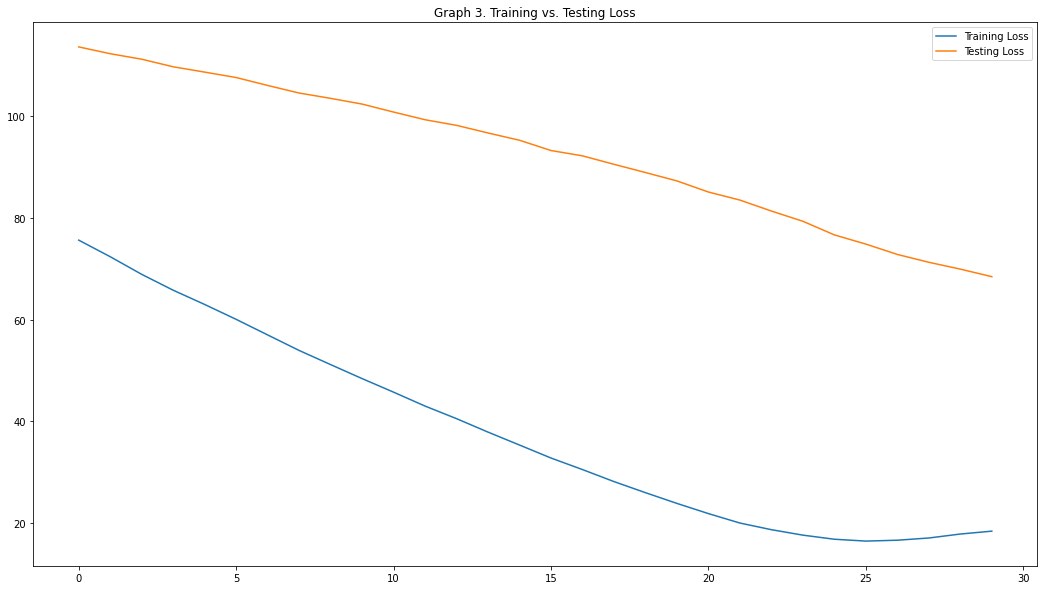

In [135]:
# lets look at the predictions 
plt.plot(train_history, label='Training Loss')
plt.plot(test_history, label='Testing Loss')
#plt.ylim((1,10))
#plt.xlim((5,60))
plt.legend()
plt.title("Graph 3. Training vs. Testing Loss")
plt.show()

#### Predicting Daily Cases

We are only predicting a single value, but we can start to predict more values by taking the predicted value (y_pred) as input to the LSTM and use that to make even more predictions!

In [140]:
# lets predict more values 
with torch.no_grad():
  # a single value
  test_seq = X_test[:1]
  test_seq = test_seq.to(device)
  preds = []
  for _ in range(len(X_test)):
    # predicting on a single value 
    y_pred = model(test_seq)
    pred = torch.flatten(y_pred).item()
    preds.append(pred)
    #making the new sequences 
    new_seqs = test_seq.cpu().numpy().flatten()
    # adding the prediction to the new sequence
    new_seqs = np.append(new_seqs, [pred])
    # using the new sequence
    new_seqs = new_seqs[1:]
    test_seq = torch.as_tensor(new_seqs).view(1, SEQ_LENGTH, 1).float().to(device)

In [168]:
# now lets reverse the scaling to be able to plot it 
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()

# now we use the predicted cases 
pred_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

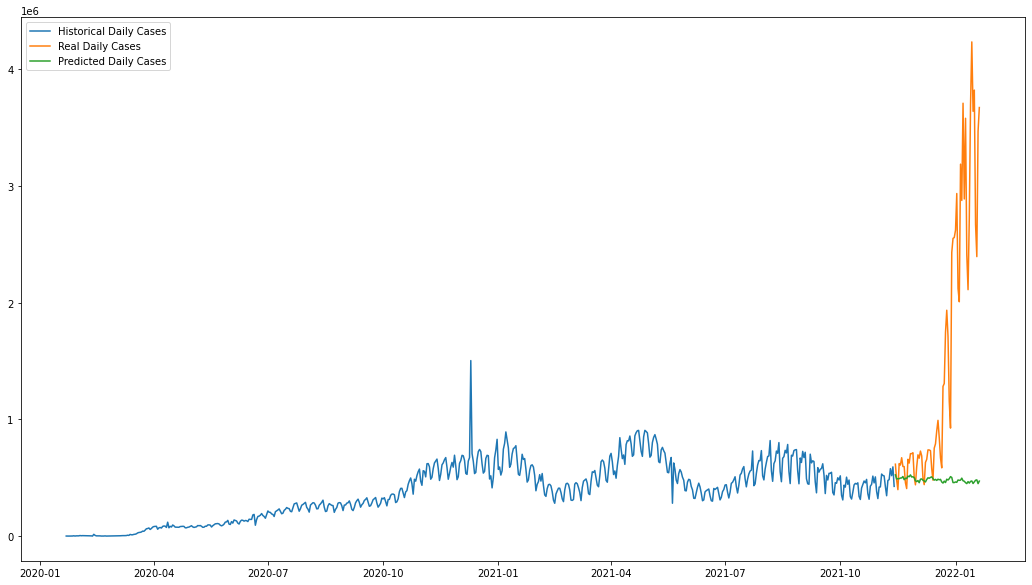

In [184]:
# lets plot to see how well we did 
plt.plot(
    daily_cases.index[:len(train_data)],
    scaler.inverse_transform(train_data).flatten(),
    label='Historical Daily Cases'
)

# the other plot --> REAL
plt.plot(
    daily_cases.index[len(train_data):len(train_data)+len(true_cases)], 
    true_cases, 
    label='Real Daily Cases'
)
# the last plot --> PREDICTED
plt.plot(
    
    daily_cases.index[len(train_data):len(train_data)+len(true_cases)], 
    pred_cases, 
    label='Predicted Daily Cases'
)

plt.legend()
plt.show()

#### Using all the data to train the model

In [196]:
# instantiante scaler
scaler = MinMaxScaler()
# fitting 
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
# all the data 
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
# creating the sequences 
X_all, y_all = create_sequences(all_data, SEQ_LENGTH)
# to tensor 
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
# instantiate the model 
# insantiate model 
x_model = nCOV_LSTM(n_features=1, n_hidden=512,seq_len=SEQ_LENGTH, DEVICE=device, n_layers=2)
# sending to device
x_model = x_model.to(device)
#ttraining the model
x_model, train_history, _ = train_LSTM_model(x_model, X_train, y_train,100, device)


TRAINING: EPOCH: 0 LOSS: 47.04938507080078

TRAINING: EPOCH: 10 LOSS: 16.539140701293945

TRAINING: EPOCH: 20 LOSS: 16.53706169128418

TRAINING: EPOCH: 30 LOSS: 16.485414505004883

TRAINING: EPOCH: 40 LOSS: 16.46211814880371

TRAINING: EPOCH: 50 LOSS: 16.377498626708984

TRAINING: EPOCH: 60 LOSS: 16.325340270996094

TRAINING: EPOCH: 70 LOSS: 16.30404281616211

TRAINING: EPOCH: 80 LOSS: 16.29227066040039

TRAINING: EPOCH: 90 LOSS: 16.15147590637207


#### Lets predict into the future! 

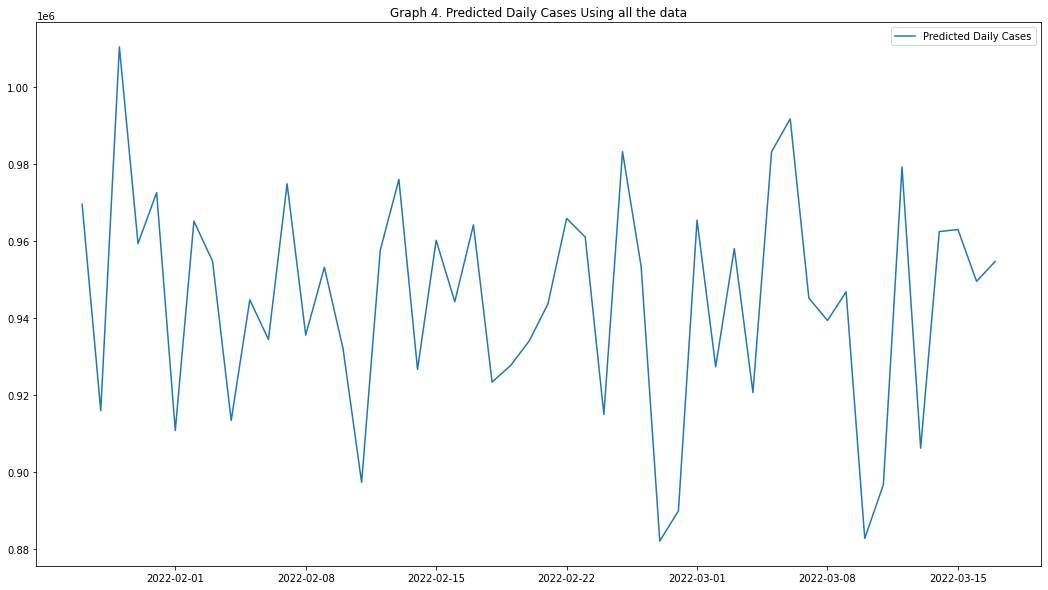

In [208]:
TO_PREDICT = 50

with torch.no_grad():
  test_seq = X_all[:1]
  test_seq = test_seq.to(device)
  preds = []
  for _ in range(TO_PREDICT):
    #predicting 
    y_pred = x_model(test_seq)
    pred = torch.flatten(y_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, SEQ_LENGTH, 1).float().to(device)


# the predicted cases 
pred_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
).flatten()

daily_cases.index[-1]

# we create a predicted index range 
pred_idx = pd.date_range(
    start=daily_cases.index[-1], 
    periods=TO_PREDICT+1,
    closed='right'
)
# get a series out of it 
pred_cases = pd.Series(
    data = pred_cases, 
    index=pred_idx
)

#plotting 
plt.plot(
         pred_cases,
         label='Predicted Daily Cases'
         )
plt.legend()
plt.title("Graph 4. Predicted Daily Cases Using all the data")
plt.show()

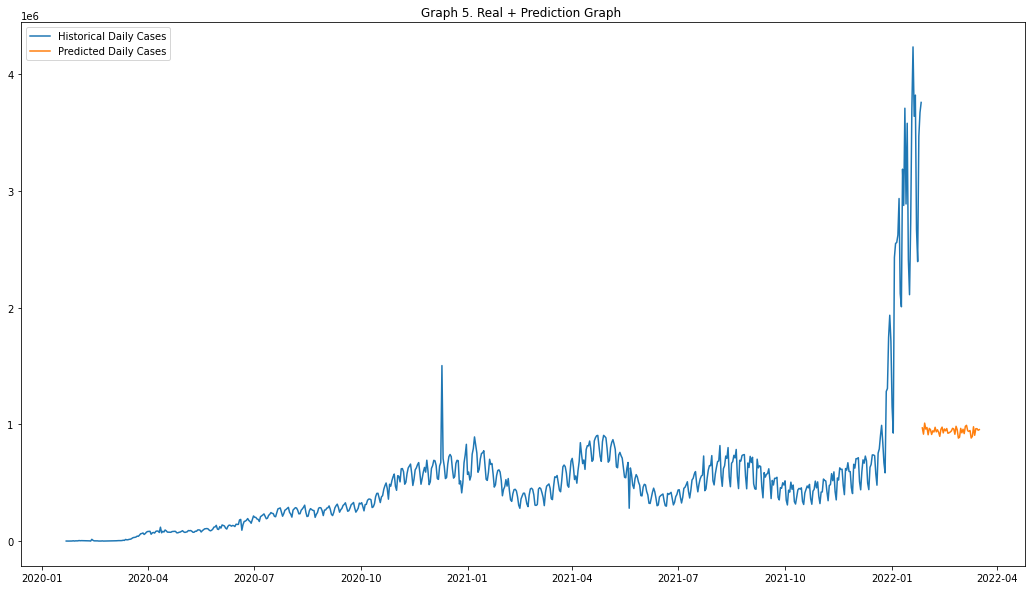

In [209]:
# using all the data 
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(pred_cases , label='Predicted Daily Cases' )
plt.legend()
plt.title("Graph 5. Real + Prediction Graph ")
plt.show()